# Brain stroke detection from CT scans via 3D Convolutional Neural Network

**Author**: Gut Gaviriel Halag and Yoav Harel

**Created**: 2023/06/16

**Description**: Train a 3D Convolutional Neural Network to detect presence of brain stroke from CT scans.

## Introduction

The [Brain Stroke CT Image Dataset](https://www.kaggle.com/datasets/afridirahman/brain-stroke-ct-image-dataset) from Kaggle provides normal and stroke brain Computer Tomography (CT) scans. The dataset presents very low activity even though it has been uploaded more than 2 years ago. It may be probably due to its quite low usability (3.13). The challenge is to get some interesting result, i.e., to try to perform brain stroke detection, even from this low-quality CT scans dataset. The followed approach is based on the usage of a 3D Convolutional Neural Network (CNN) in place of a standard 2D one. 2D CNNs are commonly used to process both grayscale (1 channel) and RGB images (3 channels), while a 3D CNN represents the 3D equivalent since it takes as input a 3D volume or a sequence of 2D frames, e.g. slices in a CT scan. 
The provided example takes inspiration from the great work [3D image classification from CT scans](https://keras.io/examples/vision/3D_image_classification/) done by [Hasib Zunair](https://twitter.com/hasibzunair) who clearly demonstrated how to use a 3D CNN to predict the presence of viral pneumonia from CT scans.

## Dataset exploration

The CT scans dataset is public available on Kaggle, but for the sake of simplicy it has been made available also on my Github profile so it can be easily downloaded without the need of an API key and additional Python packages.

In [1]:
import os
import zipfile
import tensorflow as tf

# Download dataset from Github
url = "https://github.com/HarelYoav/brain_stroke_imgs/releases/download/brain_stoke_ct_images/brain_stroke_ct.zip"
filename = os.path.join(os.getcwd(), "brain_stroke_ct.zip")
tf.keras.utils.get_file(filename, url)

# Unzip dataset
with zipfile.ZipFile("brain_stroke_ct.zip", "r") as z_fp:
    z_fp.extractall("brain_stroke_ct/")

The dataset contains both normal and stroke images respectively in the Normal and Stroke folders.

It is important to clarify the dataset does not contain CT scans, which are usually provided as DICOM or NIfTI files, but the CT scan slices in JPEG format (most probably extracted from DICOM or NIfTI files). A previous post clearly explains how to extract slice images from a DICOM file. Giving a further look to the slice images it is easy to understand the naming convention PATIENT_ID (SLICE_ID).jpg, e.g. 49 (1).jpg, 49 (2).jpg and for each patient ID several slices are available. The following function is able to plot up to 40 slices (if available) for a specific patient ID.

In [2]:
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import numpy as np

def plot_scan_from_path(slices_path, patient_id):
    """Plot 40 slices for a patient ID"""
    num_rows = 4
    num_columns = 10
    factor = 1.2
    f, axarr = plt.subplots(
        num_rows,
        num_columns,
        figsize=(num_columns*factor, num_rows*factor),
    )
    f.suptitle(f"Patient {patient_id}", y=1.1)
    image_id = 1
    for i in range(num_rows):
        for j in range(num_columns):
            try:
                img = imageio.imread(f'{slices_path}/{patient_id} ({image_id}).jpg')
            except Exception as e:
                print(e)
                img = np.zeros((2,2))
            finally:
                axarr[i, j].imshow(img, cmap='gray')
                axarr[i, j].axis('off')
                image_id += 1
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

Let's start with patient 49:

No such file: 'C:\Users\yoavb\Documents\cs_study\third_year\Semester_B\Image processing\project\Untitled Folder\brain_stroke_ct\Normal\49 (34).jpg'
No such file: 'C:\Users\yoavb\Documents\cs_study\third_year\Semester_B\Image processing\project\Untitled Folder\brain_stroke_ct\Normal\49 (35).jpg'
No such file: 'C:\Users\yoavb\Documents\cs_study\third_year\Semester_B\Image processing\project\Untitled Folder\brain_stroke_ct\Normal\49 (36).jpg'
No such file: 'C:\Users\yoavb\Documents\cs_study\third_year\Semester_B\Image processing\project\Untitled Folder\brain_stroke_ct\Normal\49 (37).jpg'
No such file: 'C:\Users\yoavb\Documents\cs_study\third_year\Semester_B\Image processing\project\Untitled Folder\brain_stroke_ct\Normal\49 (38).jpg'
No such file: 'C:\Users\yoavb\Documents\cs_study\third_year\Semester_B\Image processing\project\Untitled Folder\brain_stroke_ct\Normal\49 (39).jpg'
No such file: 'C:\Users\yoavb\Documents\cs_study\third_year\Semester_B\Image processing\project\Untitled Folder\

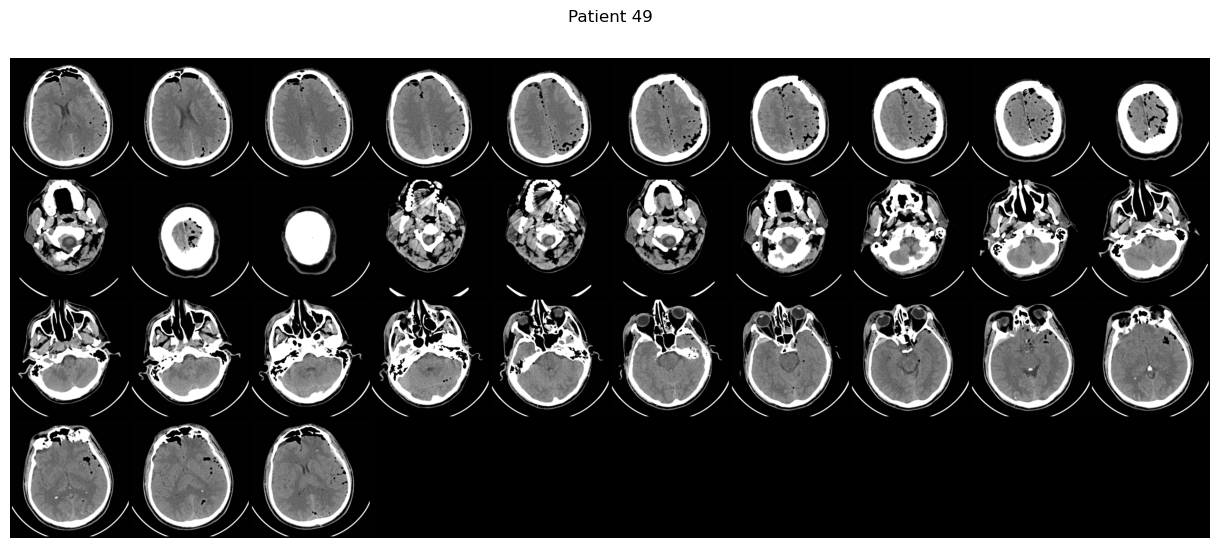

In [3]:
plot_scan_from_path(slices_path='brain_stroke_ct/Normal', patient_id=49)

Patient 49 has 33 slices, but it is fundamental to underline the slices are not correctly sorted. It seems the slices go from the middle of the head to the top, but then they suddenly start back from the bottom. This may be among the reasons the dataset usability is low. This may not be an issue for a 2D CNN since it takes single images as input, but is a big obstacle for a 3D CNN where the volumetric representation of the brain is needed.

No such file: 'C:\Users\yoavb\Documents\cs_study\third_year\Semester_B\Image processing\project\Untitled Folder\brain_stroke_ct\Normal\50 (13).jpg'
No such file: 'C:\Users\yoavb\Documents\cs_study\third_year\Semester_B\Image processing\project\Untitled Folder\brain_stroke_ct\Normal\50 (15).jpg'
No such file: 'C:\Users\yoavb\Documents\cs_study\third_year\Semester_B\Image processing\project\Untitled Folder\brain_stroke_ct\Normal\50 (17).jpg'
No such file: 'C:\Users\yoavb\Documents\cs_study\third_year\Semester_B\Image processing\project\Untitled Folder\brain_stroke_ct\Normal\50 (19).jpg'
No such file: 'C:\Users\yoavb\Documents\cs_study\third_year\Semester_B\Image processing\project\Untitled Folder\brain_stroke_ct\Normal\50 (21).jpg'
No such file: 'C:\Users\yoavb\Documents\cs_study\third_year\Semester_B\Image processing\project\Untitled Folder\brain_stroke_ct\Normal\50 (23).jpg'
No such file: 'C:\Users\yoavb\Documents\cs_study\third_year\Semester_B\Image processing\project\Untitled Folder\

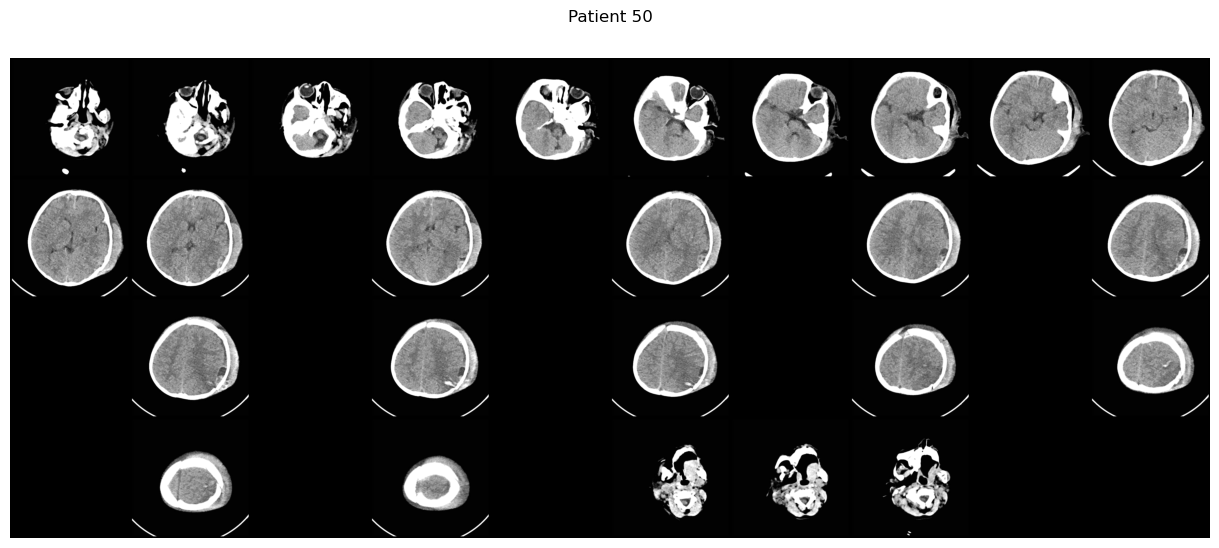

In [4]:
plot_scan_from_path(slices_path='brain_stroke_ct/Normal', patient_id=50)

In [5]:
INPUT_PATH='brain_stroke_ct'
OUTPUT_PATH='brain_stroke_ct_fixed'
NORMAL_INPUT_PATH=f'{INPUT_PATH}/Normal'
NORMAL_OUTPUT_PATH=f'{OUTPUT_PATH}/Normal'
STROKE_INPUT_PATH=f'{INPUT_PATH}/Stroke'
STROKE_OUTPUT_PATH=f'{OUTPUT_PATH}/Stroke'

NORMAL_SORTING_CONFIG = {
    49:  [14, 15, 16, 11, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13],
    50:  [36, 37, 38, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34],
    51:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50],
    52:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
    53:  [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 26, 28, 29, 31, 33, 35, 37, 39, 41, 43, 1, 2, 3, 4],
    54:  [20, 21, 22, 23, 24, 25, 26, 27, 28, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
    55:  [30, 31, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    56:  [33, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
    57:  [32, 33, 34, 35, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
    59:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
    60:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    61:  [25, 26, 27, 28, 29, 30, 31, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
    62:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
    63:  [33, 34, 35, 36, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
    64:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26],
    65:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    95:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    96:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
    98:  [29, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28],
    99:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    100: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    101: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
    102: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
    103: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
    104: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    105: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    106: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    107: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    108: [25, 26, 27, 28, 29, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
    109: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28],
    110: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28],
    111: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
    112: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26],
    113: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28],
    114: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    115: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
    116: [31, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    117: [29, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28],
    118: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    119: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
    120: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    121: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    122: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28],
    123: [39, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38],
    124: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    125: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
    126: [30, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    127: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
    128: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28],
    129: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    130: [26, 27, 28, 29, 30, 31, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
}

STROKE_SORTING_CONFIG = {
    58: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36],
    66: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 38, 39, 40, 41],
    67: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 21, 23, 25, 27, 28, 29, 30, 31, 32, 33],
    68: [1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36],
    69: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36],
    70: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 42, 43, 44, 45, 46, 47, 48],
    71: [48, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46],
    72: [31, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    73: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 30, 32, 34, 36, 38, 39],
    74: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 18, 20, 22, 23, 25, 27, 29, 31, 33, 35, 37, 39, 40, 41, 42, 43, 44, 45, 46],
    75: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 49],
    76: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 40, 41, 42, 43],
    77: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43],
    78: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 17, 19, 21, 23, 25, 26, 28, 30, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42],
    79: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
    80: [1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 15, 16, 18, 20, 22, 24, 26, 28, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40],
    81: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 44],
    82: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
    83: [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 29, 31, 33, 35, 36, 37, 38, 1, 2, 3, 4],
    84: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
    85: [21, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 20],
    86: [31, 32, 33, 34, 35, 36, 1, 2, 3, 4, 6, 8, 10, 12, 14, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    87: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 40, 41, 42, 43, 44],
    88: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 26, 28, 30, 32, 34, 35, 36, 37],
    89: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 21, 23, 25, 27, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43],
    90: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
    91: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 19, 21, 23, 25, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
    92: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 19, 20, 21, 23, 25, 27, 29, 31, 32, 33, 34, 36, 38, 40, 42],
    93: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36],
    94: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 44, 45, 46],
    97: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 35, 36, 37, 38, 39, 40],
}

In [6]:
import os
import shutil

def sort_slices(input_path, output_path, patient_id, order):
    """Copy the slices in the correct order"""
    # Create output folder for sorted images (if it does not exist)
    if not os.path.exists(output_path):
        os.makedirs(output_path, exist_ok=True)

    # Move the image to the output path with a name based on the correct sorting order
    for new_id in range(1, len(order)+1):
        old_id = order[new_id-1]
        shutil.copyfile(f'{input_path}{os.sep}{patient_id} ({old_id}).jpg', f'{output_path}{os.sep}{patient_id} ({new_id}).jpg')


# Normal slices sorting
for patient_id, order in NORMAL_SORTING_CONFIG.items():
    sort_slices(
      input_path=NORMAL_INPUT_PATH,
      output_path=NORMAL_OUTPUT_PATH,
      patient_id=patient_id,
      order=order)

# Stroke slices sorting
for patient_id, order in STROKE_SORTING_CONFIG.items():
    sort_slices(
      input_path=STROKE_INPUT_PATH,
      output_path=STROKE_OUTPUT_PATH,
      patient_id=patient_id,
      order=order)

Let's try to plot again CT slices for both patients 49 and 50:

No such file: 'C:\Users\yoavb\Documents\cs_study\third_year\Semester_B\Image processing\project\Untitled Folder\brain_stroke_ct_fixed\Normal\49 (34).jpg'
No such file: 'C:\Users\yoavb\Documents\cs_study\third_year\Semester_B\Image processing\project\Untitled Folder\brain_stroke_ct_fixed\Normal\49 (35).jpg'
No such file: 'C:\Users\yoavb\Documents\cs_study\third_year\Semester_B\Image processing\project\Untitled Folder\brain_stroke_ct_fixed\Normal\49 (36).jpg'
No such file: 'C:\Users\yoavb\Documents\cs_study\third_year\Semester_B\Image processing\project\Untitled Folder\brain_stroke_ct_fixed\Normal\49 (37).jpg'
No such file: 'C:\Users\yoavb\Documents\cs_study\third_year\Semester_B\Image processing\project\Untitled Folder\brain_stroke_ct_fixed\Normal\49 (38).jpg'
No such file: 'C:\Users\yoavb\Documents\cs_study\third_year\Semester_B\Image processing\project\Untitled Folder\brain_stroke_ct_fixed\Normal\49 (39).jpg'
No such file: 'C:\Users\yoavb\Documents\cs_study\third_year\Semester_B\Image

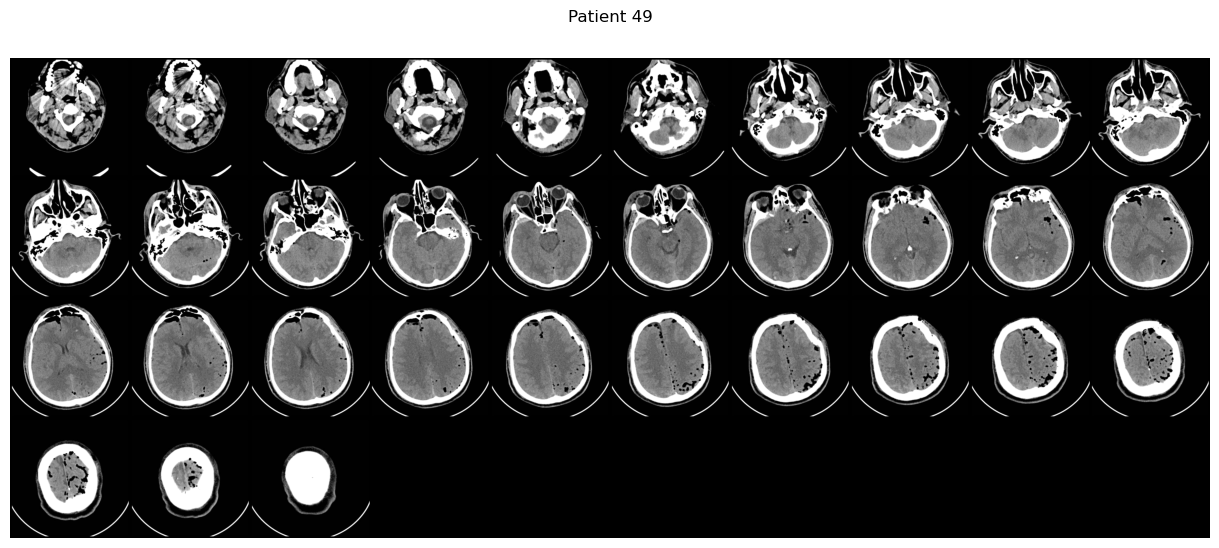

In [7]:
plot_scan_from_path(slices_path=NORMAL_OUTPUT_PATH, patient_id=49)

No such file: 'C:\Users\yoavb\Documents\cs_study\third_year\Semester_B\Image processing\project\Untitled Folder\brain_stroke_ct_fixed\Normal\50 (27).jpg'
No such file: 'C:\Users\yoavb\Documents\cs_study\third_year\Semester_B\Image processing\project\Untitled Folder\brain_stroke_ct_fixed\Normal\50 (28).jpg'
No such file: 'C:\Users\yoavb\Documents\cs_study\third_year\Semester_B\Image processing\project\Untitled Folder\brain_stroke_ct_fixed\Normal\50 (29).jpg'
No such file: 'C:\Users\yoavb\Documents\cs_study\third_year\Semester_B\Image processing\project\Untitled Folder\brain_stroke_ct_fixed\Normal\50 (30).jpg'
No such file: 'C:\Users\yoavb\Documents\cs_study\third_year\Semester_B\Image processing\project\Untitled Folder\brain_stroke_ct_fixed\Normal\50 (31).jpg'
No such file: 'C:\Users\yoavb\Documents\cs_study\third_year\Semester_B\Image processing\project\Untitled Folder\brain_stroke_ct_fixed\Normal\50 (32).jpg'
No such file: 'C:\Users\yoavb\Documents\cs_study\third_year\Semester_B\Image

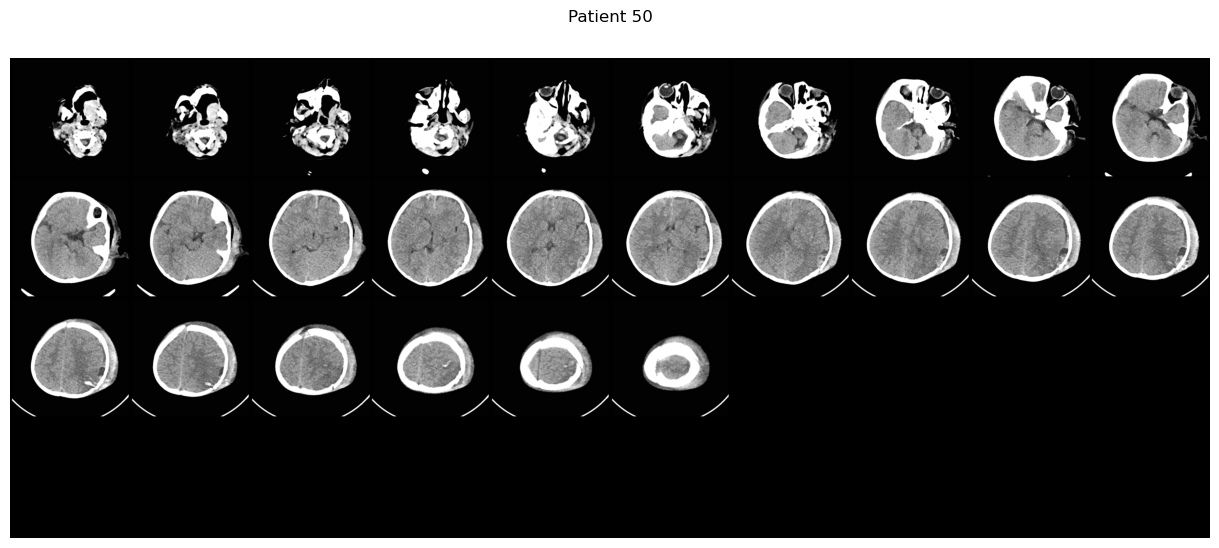

In [8]:
plot_scan_from_path(slices_path=NORMAL_OUTPUT_PATH, patient_id=50)

## Dataset loading and preprocessing

In [9]:
NORMAL_PATH = 'brain_stroke_ct_fixed/Normal'
STROKE_PATH = 'brain_stroke_ct_fixed/Stroke'

Before going deeper into data loading it can be interesting to give a look to a single CT slice.

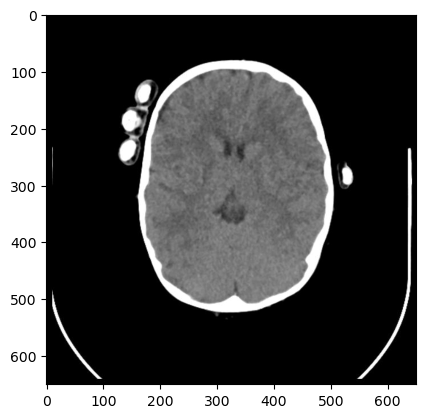

In [10]:
import imageio.v2 as imageio
import matplotlib.pyplot as plt

image = imageio.imread(f'{STROKE_PATH}/67 (15).jpg')
plt.imshow(image, cmap="gray")

As it is possible to see, the image presents some artifacts that may hinder the CNN training process. [Vicente Rodríguez](https://vincentblog.xyz/posts/medical-images-in-python-computed-tomography) provided a nice example of CT image denoising that lead to the creation of the following `remove_noise` function:

In [11]:
from scipy import ndimage
from skimage import morphology
import numpy as np

def remove_noise(image, display=False):
    """Remove slice noise"""
    # morphology.dilation creates a segmentation of the image
    # If one pixel is between the origin and the edge of a square of size
    # 3x3, the pixel belongs to the same class
    segmentation = morphology.dilation(image, np.ones((3, 3)))
    segmentation[segmentation < 25] = 0
    segmentation[segmentation > 25] = 1
    labels, label_nb = ndimage.label(segmentation)
    label_count = np.bincount(labels.ravel().astype(int))

    # The size of label_count is the number of classes/segmentations found.
    # The first class is not used since it's the background.
    label_count[0] = 0

    # A mask with the class with more pixels is created
    # since it should represent the brain
    mask = labels == label_count.argmax()

    # Improve the brain mask
    mask = morphology.dilation(mask, np.ones((5, 5)))
    mask = ndimage.binary_fill_holes(mask)
    mask = morphology.dilation(mask, np.ones((3, 3)))

    # Since the pixels in the mask are zeros and ones,
    # it is possible to multiple the original image to only keep the brain region
    masked_image = mask * image

    if display:
        plt.figure(figsize=(10, 2.5))
        plt.subplot(141)
        plt.imshow(image, cmap=plt.cm.bone)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(142)
        plt.imshow(mask, cmap=plt.cm.bone)
        plt.title('Mask')
        plt.axis('off')

        plt.subplot(143)
        plt.imshow(masked_image, cmap=plt.cm.bone)
        plt.title('Clean Image')
        plt.axis('off')

    return masked_image

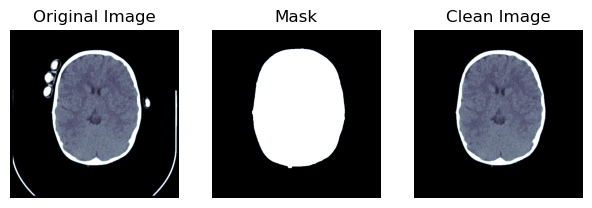

In [12]:
denoised_image = remove_noise(image, display=True)

As expected, the CT artifacts are not present anymore.

It is worth noting despite the CT slices have been correctly sorted and there are no holes in slice sequences anymore, the dataset is still not so straightforward to import since the number of slices per patient is not always the same. The load_dataset function appears quite complex because it has to execute in sequence multiple steps to load and pre-process the entire image dataset:

count_slices: counts the number of slices per patient
merge_slices: denoises (optionally) and merges all patient slices into a single scan
normalize_scan: normalizes the scan values to the interval [0, 1]
resize_scan: resizes the scan across x, y and z axis to uniform the scan sizes to fixed values
Finally, the returned dataset is a 4D array, i.e., an array of scans (3D images).

In [13]:
import numpy as np
from tqdm import tqdm


def resize_scan(scan):
    """Resize the CT scan to a desired uniform size across all axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 224
    desired_height = 224
    # Get current depth
    current_depth = scan.shape[-1]
    current_width = scan.shape[0]
    current_height = scan.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    scan = ndimage.rotate(scan, 90, reshape=False)
    # Resize across z-axis
    scan = ndimage.zoom(scan, (width_factor, height_factor, depth_factor), order=1)
    return scan


def normalize_scan(scan):
    """Normalize the scan to the interval [0, 1]"""
    min = 0
    max = 255
    scan[scan < min] = min
    scan[scan > max] = max
    scan = (scan - min) / (max - min)
    scan = scan.astype("float32")
    return scan


def merge_slices(path, patient_id, slice_count, denoise=False):
    """Merge all the slices for a patient into a scan"""
    if denoise:
        scan = tuple(remove_noise(imageio.imread(f'{path}/{patient_id} ({slice_id}).jpg')) for slice_id in range(1, slice_count+1))
    else:
        scan = tuple(imageio.imread(f'{path}/{patient_id} ({slice_id}).jpg') for slice_id in range(1, slice_count+1))

    return np.dstack(scan)


def count_slices(path):
    """Analyze the slices path and returns a dictionary with the slices count associated to each patient"""
    slice_dict = {}
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            patient_id = int(filename.split()[0])
            if patient_id not in slice_dict:
                slice_dict[patient_id] = 1
            else:
                slice_dict[patient_id] = slice_dict[patient_id] + 1

    return slice_dict


def collect_scan(path, patient_id, slice_count):
    """Collect a scan for a patient id"""
    # Get a single CT scan by merging all the slices from a single patient
    # Before getting merged the slices are also denoised
    scan = merge_slices(path, patient_id, slice_count, denoise=True)

    # Normalize the CT scan to the interval [0, 1]
    scan = normalize_scan(scan)

    # Resize the CT scan to uniform the size
    scan = resize_scan(scan)

    return scan


def load_dataset(path):
    """Return the scans dataset as a 4D array""" 
    # Get a dictionary with patient IDs and slice count per patient
    slices_dict = count_slices(path)

    # Collect scans for each patient id
    dataset = np.array([collect_scan(path, patient_id, slice_count) for patient_id, slice_count in tqdm(slices_dict.items())])

    return dataset

In [14]:
normal_dataset = load_dataset(path=NORMAL_PATH)
stroke_dataset = load_dataset(path=STROKE_PATH)

100%|██████████| 31/31 [01:34<00:00,  3.05s/it]


In [15]:
normal_dataset.shape, stroke_dataset.shape

((51, 224, 224, 64), (31, 224, 224, 64))

The normal and stroke datasets are represented by rank-3 tensors of shape (samples, height, width, depth). There are 51 normal and 31 stroke CT scans so the dataset is quite unbalanced.

The function plot_slices_from_dataset can be used to plot an entire CT scan from the loaded dataset.

In [16]:
def plot_scan_from_dataset(num_rows, num_columns, width, height, data, title):
    """Plot a scan from dataset"""
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    f.suptitle(title, y=1.1)
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

The first scan from both the normal and stroke datasets is shown hereafter.

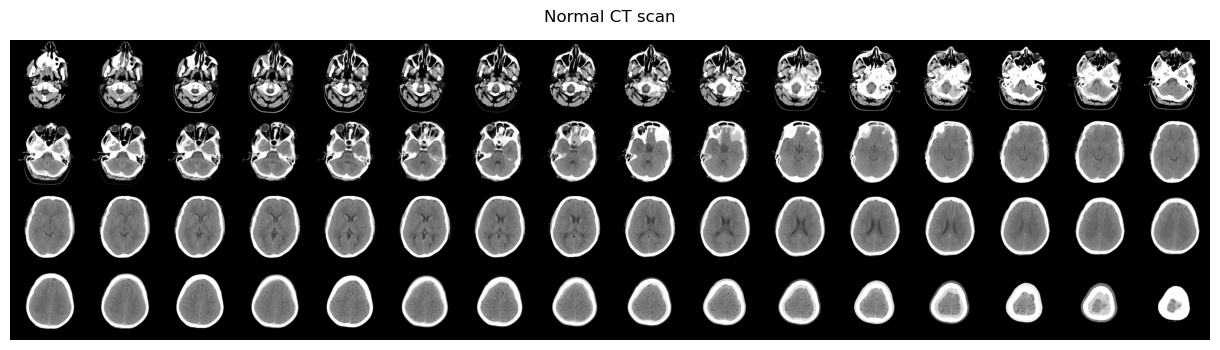

In [19]:
plot_scan_from_dataset(4, 16, 224, 224, normal_dataset[0, :, :, :], "Normal CT scan")

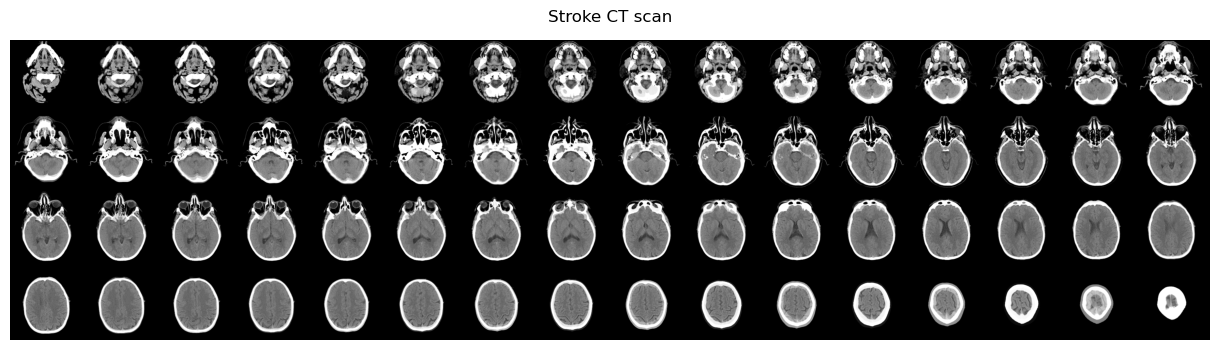

In [20]:
plot_scan_from_dataset(4, 16, 224, 224, stroke_dataset[0, :, :, :], "Stroke CT scan")

Both the datasets are now splitted and merged into training and validation datasets with a ratio of 70% and 30%.

In [21]:
# For the CT scans having presence of stroke assign 1 otherwise 0.
normal_labels = np.array([0 for _ in range(len(normal_dataset))])
stroke_labels = np.array([1 for _ in range(len(stroke_dataset))])

# Split data in the ratio 70%-30% for training and validation.
import math
VALIDATION_SPLIT = 0.7
normal_train_len = math.ceil(VALIDATION_SPLIT*len(normal_labels))
stroke_train_len = math.ceil(VALIDATION_SPLIT*len(stroke_labels))
x_train = np.concatenate((normal_dataset[:normal_train_len], stroke_dataset[:stroke_train_len]), axis=0)
y_train = np.concatenate((normal_labels[:normal_train_len], stroke_labels[:stroke_train_len]), axis=0)
x_val = np.concatenate((normal_dataset[normal_train_len:], stroke_dataset[stroke_train_len:]), axis=0)
y_val = np.concatenate((normal_labels[normal_train_len:], stroke_labels[stroke_train_len:]), axis=0)

print(f"Training samples")
print(f"Normal: {normal_train_len}")
print(f"Stroke: {stroke_train_len}")
print(f"Total: {x_train.shape[0]}")
print()
print(f"Validation samples")
print(f"Normal: {len(normal_dataset) - normal_train_len}")
print(f"Stroke: {len(stroke_dataset) - stroke_train_len}")
print(f"Total: {x_val.shape[0]}")

Training samples
Normal: 36
Stroke: 22
Total: 58

Validation samples
Normal: 15
Stroke: 9
Total: 24


## Dataset augmentation

A machine learning model performs better and is more accurate when the dataset is rich and sufficient. Deep learning in general, but particularly in medical imaging, requires a large amount of training data in order to obtain good performance and avoid overfitting. To meet these challenges, increasing the quantity of training data is a common solution. Data augmentation is a common approach to enhance the performance and the results of machine learning models. It allows a small dataset to be rebalanced or enriched for any reason (time-consuming manual annotations, lack of accessible data...). The augmentation techniques must make sense with respect to the type of analysis desired and therefore positively influence the performance of the model during the learning phase: by applying a large number of augmentations, the performance will not necessarily be better. There are several types of transformations for medical images, but few examples which can be seen as good starting point for CT scans are provided in the following.

## Rotation
This transformation consists of rotating the original image according to a desired angle. In medical image analysis, this represents a common augmentation technique. In this case the scan is rotated around z-axis by a random angle in the interval [-45, 45] degrees.

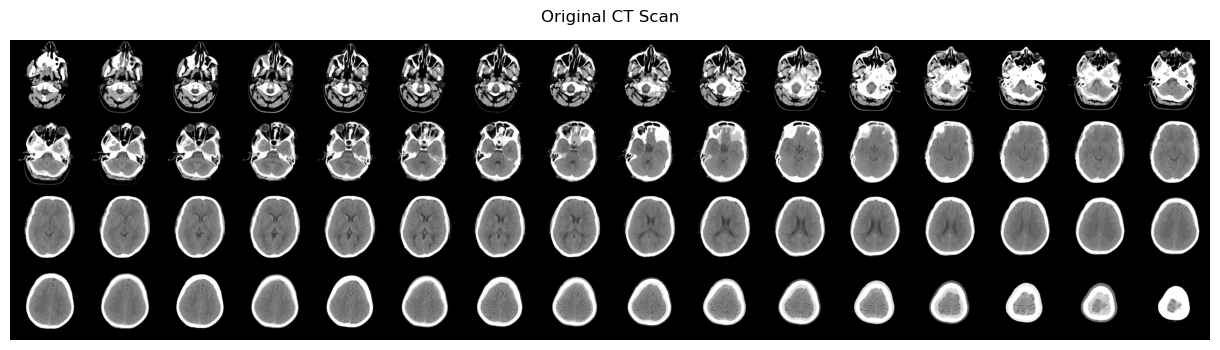

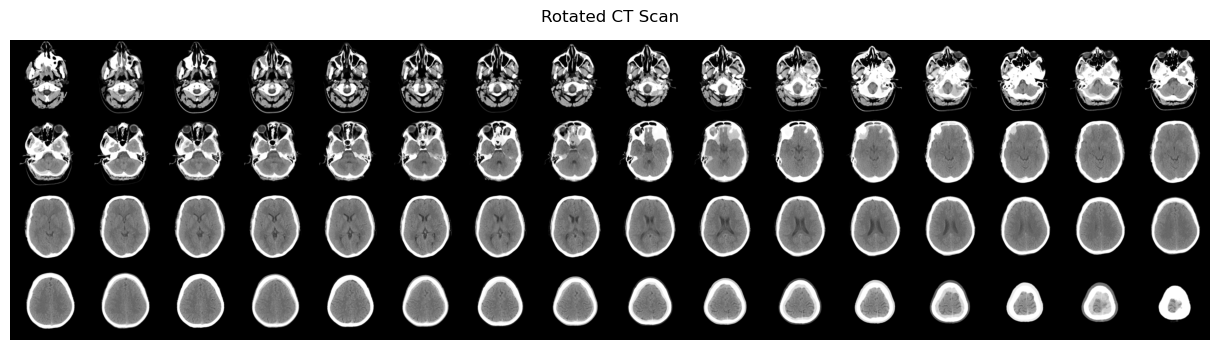

In [22]:
rotation_layer = tf.keras.layers.RandomRotation(factor=(-0.125, 0.125), fill_mode='constant', fill_value=0)

plot_scan_from_dataset(4, 16, 224, 224, x_train[0, :, :, :], "Original CT Scan")
plot_scan_from_dataset(4, 16, 224, 224, rotation_layer(x_train[0, :, :, :]), "Rotated CT Scan")

The training and validation data loaders must be defined. In this case, data augmentation is not applied through the data loader but directly on the CNN by adding the related augmentation layers.

In [86]:
from pathlib import Path

seed_train_validation = 1 # Must be same for train_ds and val_ds
shuffle_value = True
validation_split = 0.3


data_dir = Path('brain_stroke_ct').resolve()

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size = (224, 224),
    validation_split = validation_split,
    subset = "training",
    seed = seed_train_validation,
    color_mode = 'rgb',
    shuffle = shuffle_value,
    batch_size=32,
label_mode='categorical')


val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size = (224, 224),
    validation_split = validation_split,
    subset = "validation",
    seed = seed_train_validation,
    color_mode = 'rgb',
    shuffle = shuffle_value,
    batch_size=32,
label_mode='categorical')

normalization_layer = tf.keras.layers.Rescaling(1./255)

def change_inputs(images, labels):
    x = tf.image.resize(normalization_layer(images),[224, 224], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return x, labels

train_ds = train_ds.map(change_inputs)
val_ds = val_ds.map(change_inputs)


val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

Found 2515 files belonging to 2 classes.
Using 1761 files for training.
Found 2515 files belonging to 2 classes.
Using 754 files for validation.


## Model definition


In [90]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax



# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
  
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=(-0.125, 0.125), fill_mode='constant', fill_value=0),
        layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='constant', fill_value=0),
        layers.RandomFlip(mode='vertical'),
        layers.RandomContrast(factor=(0, 1.2)),
    ],
    name="img_augmentation",)


base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= None, input_shape= img_shape, pooling= 'max')


model = Sequential([
    layers.Input(shape=(img_shape)),
    img_augmentation,
    base_model,
    layers.BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    layers.Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    layers.Dropout(rate= 0.45, seed= 123),
    layers.Dense(2, activation='softmax')
])



  # Compile the model
model.compile(loss="binary_crossentropy", optimizer=Adamax(learning_rate= 0.001), metrics= ['accuracy'])
model.build()
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_augmentation (Sequentia  (None, 224, 224, 3)      0         
 l)                                                              
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization_23 (Bat  (None, 1280)             5120      
 chNormalization)                                                
                                                                 
 dense_46 (Dense)            (None, 256)               327936    
                                                                 
 dropout_23 (Dropout)        (None, 256)               0         
                                                                 
 dense_47 (Dense)            (None, 2)               

In [91]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    shuffle=True,
    verbose=1,
  )

Epoch 1/10
56/56 [==============================] - 373s 6s/step - loss: 7.0898 - accuracy: 0.5582 - val_loss: 5.9239 - val_accuracy: 0.6378
Epoch 2/10
56/56 [==============================] - 341s 6s/step - loss: 5.5154 - accuracy: 0.5713 - val_loss: 4.9109 - val_accuracy: 0.6324
Epoch 3/10
56/56 [==============================] - 331s 6s/step - loss: 4.5800 - accuracy: 0.5769 - val_loss: 4.1044 - val_accuracy: 0.6486
Epoch 4/10
56/56 [==============================] - 334s 6s/step - loss: 3.8344 - accuracy: 0.5940 - val_loss: 3.4923 - val_accuracy: 0.6270
Epoch 5/10
56/56 [==============================] - 363s 6s/step - loss: 3.2666 - accuracy: 0.5991 - val_loss: 3.0103 - val_accuracy: 0.6270
Epoch 6/10
56/56 [==============================] - 372s 7s/step - loss: 2.7993 - accuracy: 0.6087 - val_loss: 2.5834 - val_accuracy: 0.6270
Epoch 7/10
56/56 [==============================] - 362s 6s/step - loss: 2.4251 - accuracy: 0.6014 - val_loss: 2.2424 - val_accuracy: 0.6405
Epoch 8/10
56

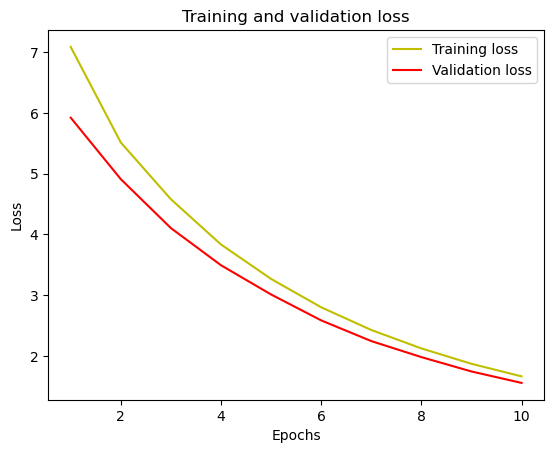

In [92]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

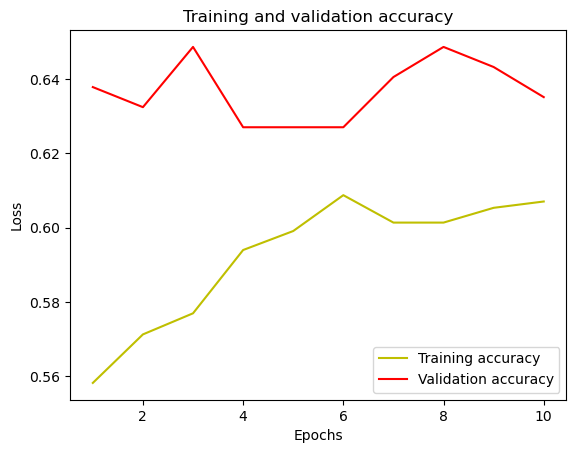

In [93]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training accuracy')
plt.plot(epochs, val_loss, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()